In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [13]:
mnist_path = 'MU.csv'
# Load the file into a pandas DataFrame
df=pd.read_csv(mnist_path)
FP1_df=df[df['channel']=='FP1']
FP2_df=df[df['channel']=='FP2']
df=pd.concat([FP1_df, FP2_df])
def convert_to_float(str):
    str_li = str.split(',')
    float_li = list(map(float, str_li))
    return float_li
df["data"]=df["data"].apply(lambda x: convert_to_float(x))
df.head()

,id,event_id,device,channel,code,size,data
1,978112,132669,MU,FP1,6,459,"[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491..."
5,978116,132670,MU,FP1,7,493,"[505.0, 515.0, 513.0, 506.0, 512.0, 520.0, 512..."
9,978120,132671,MU,FP1,6,459,"[502.0, 516.0, 514.0, 508.0, 514.0, 520.0, 520..."
13,978124,132672,MU,FP1,6,459,"[512.0, 529.0, 527.0, 526.0, 522.0, 522.0, 525..."
17,978128,132673,MU,FP1,1,493,"[506.0, 511.0, 513.0, 518.0, 505.0, 522.0, 526..."


In [4]:
# Function to resample an array to the target length
def resample_array(array, target_length):
    # Create an array of indices for the input array
    input_indices = np.linspace(0, len(array)-1, len(array))

    # Create an array of indices for the resampled array
    resampled_indices = np.linspace(input_indices.min(), input_indices.max(), target_length)

    # Create a linear interpolation function based on the input array
    interpolator = interp1d(input_indices, array, kind='linear')

    # Use the interpolator to create the resampled array
    resampled_array = interpolator(resampled_indices)

    return resampled_array.tolist()

In [5]:
median_length=459
# Resample all the data arrays to the median length(use lambda function and apply)
df["resampled_data"] = df["data"].apply(lambda a: resample_array(a, median_length))

# Check the length of the resampled arrays
df["resampled_data_length"] = df["resampled_data"].apply(len)

# Display the first few rows of the updated DataFrame
df.head()

,id,event_id,device,channel,code,size,data,resampled_data,resampled_data_length
1,978112,132669,MU,FP1,6,459,"[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491...","[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491...",459
5,978116,132670,MU,FP1,7,493,"[505.0, 515.0, 513.0, 506.0, 512.0, 520.0, 512...","[505.0, 514.8515283842795, 511.9606986899563, ...",459
9,978120,132671,MU,FP1,6,459,"[502.0, 516.0, 514.0, 508.0, 514.0, 520.0, 520...","[502.0, 516.0, 514.0, 508.0, 514.0, 520.0, 520...",459
13,978124,132672,MU,FP1,6,459,"[512.0, 529.0, 527.0, 526.0, 522.0, 522.0, 525...","[512.0, 529.0, 527.0, 526.0, 522.0, 522.0, 525...",459
17,978128,132673,MU,FP1,1,493,"[506.0, 511.0, 513.0, 518.0, 505.0, 522.0, 526...","[506.0, 511.1484716157205, 513.7423580786026, ...",459


In [6]:
data_array=np.array(df['resampled_data'].tolist())
codes=df['code'].tolist()

In [7]:
srate = 220
def time_frequency(data, cmwX, nKern):
    ''''
    Function to calculate time-frequency representation of multichannel data.

    Parameters:
    data : ndarray
        The EEG data, array of shape (channels, time).
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    channel_labels : list, optional
        The labels of the EEG channels. Must be the same length as the number of channels in the data.
        If not provided, no channel labels will be used.

    Returns:
    tf : ndarray
        The time-frequency representation of the data, array of shape (frequencies, time).
        This is the average power across all channels.
    '''

    # set up convolution parameters
    nData   = data.shape[1]
    nConv   = nData + nKern - 1
    halfwav = (nKern-1)//2

    # initialize time-frequency output matrix
    tf = np.zeros((data.shape[0], cmwX.shape[0], data.shape[1])) # channels X frequency X times

    # loop over channels
    for chani in range(data.shape[0]):

        # compute Fourier coefficients of EEG data
        eegX = fft(data[chani, :] , nConv)

        # perform convolution and extract power (vectorized across frequencies)
        as_ = ifft(cmwX * eegX[None, :], axis=1)
        as_ = as_[:, halfwav: -halfwav]
        tf[chani, :, :] = np.abs(as_) ** 2

    return tf


def get_cmwX(nData, freqrange=[1,40], numfrex=42):
    '''
    Function to calculate the Fourier coefficients of complex Morlet wavelets.

    Parameters:
    nData : int
        The number of data points.
    freqrange : list, optional
        The range of frequencies to consider. Defaults to [1,40].
    numfrex : int, optional
        The number of frequencies between the lowest and highest frequency. Defaults to 42.

    Returns:
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    frex : ndarray
        The array of frequencies.
    '''
    pi = np.pi
    wavtime = np.arange(-2,2-1/srate,1/srate)
    nKern = len(wavtime)
    nConv = nData + nKern - 1
    frex = np.linspace(freqrange[0],freqrange[1],numfrex)
   # create complex morlet wavelets array
    cmwX = np.zeros((numfrex, nConv), dtype=complex)

    # number of cycles
    numcyc = np.linspace(3,15,numfrex);
    for fi in range(numfrex):
        # create time-domain wavelet
        s = numcyc[fi] / (2*pi*frex[fi])
        twoSsquared = (2*s) ** 2
        cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )


        # compute fourier coefficients of wavelet and normalize
        cmwX[fi, :] = fft(cmw, nConv)
        cmwX[fi, :] = cmwX[fi, :] / max(cmwX[fi, :])

    return cmwX, nKern, frex



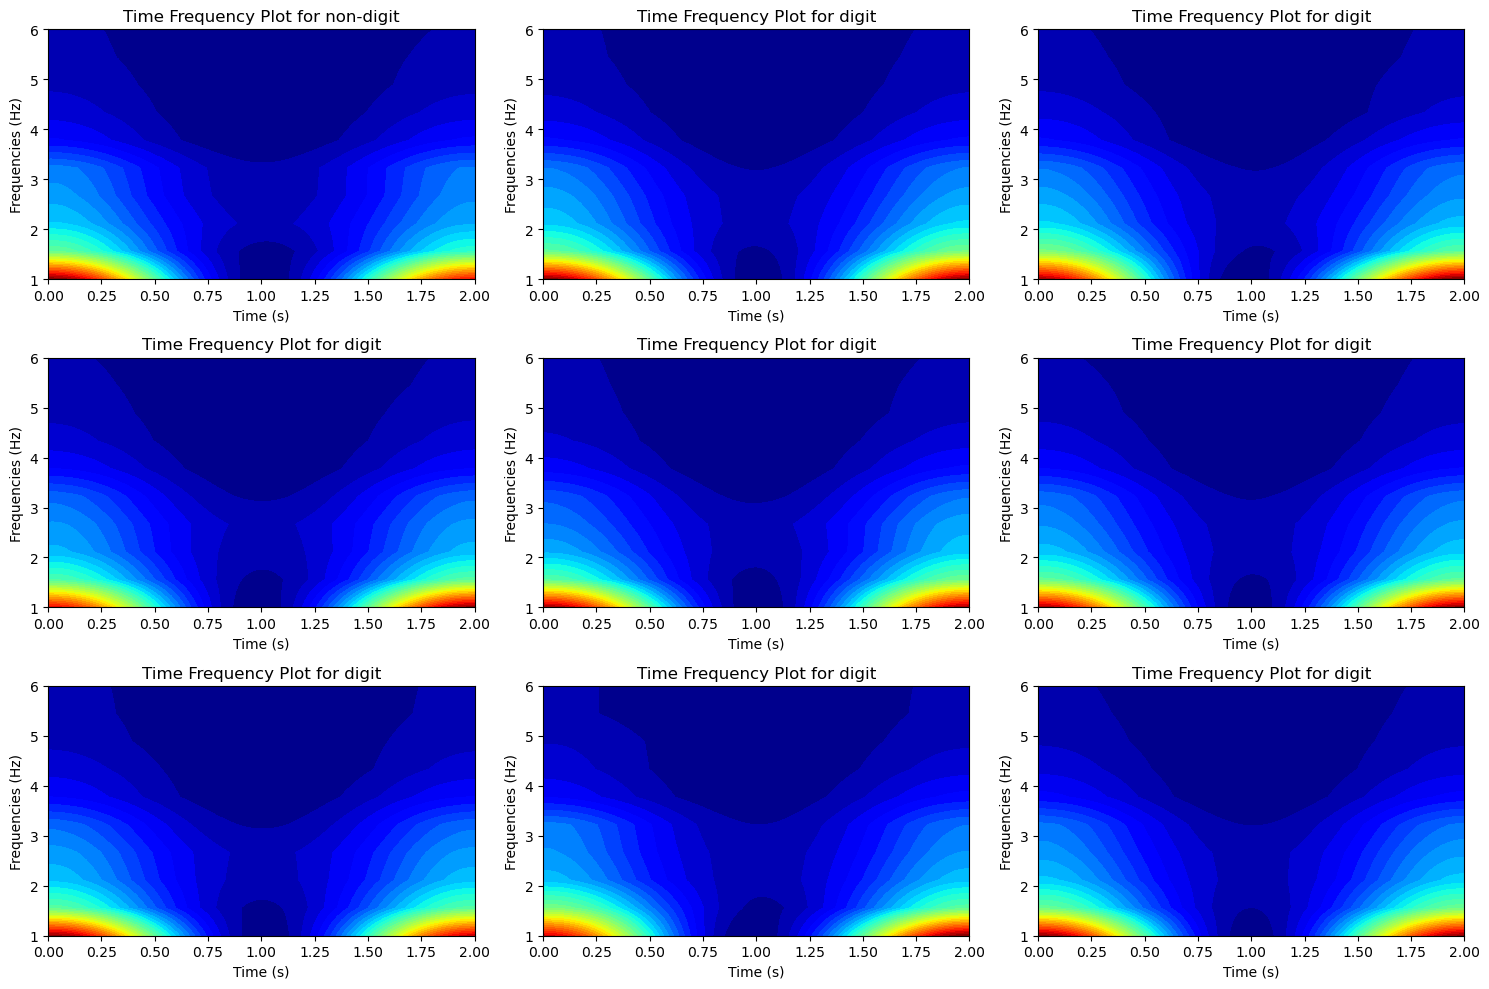

In [8]:
starting_freq = 1
end_freq = 6
num_frequencies = 10

#  Creates an array of time values starting from 0 to 2 seconds, with a total number of elements defined by median_length.
times = np.linspace(0, 2, median_length)

nData = data_array.shape[1]
cmwX, nKern, frex = get_cmwX(nData, freqrange=[starting_freq, end_freq], numfrex=num_frequencies)
tf = time_frequency(data_array, cmwX, nKern)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i,ax in enumerate(axs.flat):
  x = random.randint(0, tf.shape[0])
  contour = ax.contourf(times, frex, tf[x,:,:], 40, cmap='jet')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequencies (Hz)')
  ax.set_title(f"Time Frequency Plot for {'non-digit' if codes[x] == -1 else 'digit'}")

fig.tight_layout()

In [9]:
mw_path = 'MW.csv'
# Load the file into a pandas DataFrame
df_mw=pd.read_csv(mw_path)
df_mw["C7"] = df_mw["C7"].apply(lambda x: [float(num) for num in x.split(",")])
df_mw.head()

,C1,C2,C3,C4,C5,C6,C7
0,0,0,MW,FP1,0,1017,"[38.0, 48.0, 51.0, 44.0, 48.0, 56.0, 56.0, 41...."
1,1,1,MW,FP1,1,889,"[83.0, 74.0, 65.0, 65.0, 66.0, 55.0, 43.0, 25...."
2,2,2,MW,FP1,4,1017,"[19.0, 10.0, -2.0, -9.0, -5.0, 3.0, 8.0, 7.0, ..."
3,3,3,MW,FP1,1,1017,"[17.0, 29.0, 36.0, 26.0, 21.0, 17.0, 17.0, 13...."
4,4,4,MW,FP1,8,952,"[77.0, 74.0, 69.0, 70.0, 76.0, 75.0, 76.0, 75...."


In [10]:
median_length_mw=int(df_mw['C6'].median())
# Resample all the data arrays to the median length(use lambda function and apply)
df_mw["resampled_data"] = df_mw["C7"].apply(lambda a: resample_array(a, median_length_mw))

# Check the length of the resampled arrays
df_mw["resampled_data_length"] = df_mw["resampled_data"].apply(len)

# Display the first few rows of the updated DataFrame
df_mw.head()

,C1,C2,C3,C4,C5,C6,C7,resampled_data,resampled_data_length
0,0,0,MW,FP1,0,1017,"[38.0, 48.0, 51.0, 44.0, 48.0, 56.0, 56.0, 41....","[38.0, 48.20168067226891, 50.05882352941177, 4...",953
1,1,1,MW,FP1,1,889,"[83.0, 74.0, 65.0, 65.0, 66.0, 55.0, 43.0, 25....","[83.0, 74.60504201680672, 66.21008403361344, 6...",953
2,2,2,MW,FP1,4,1017,"[19.0, 10.0, -2.0, -9.0, -5.0, 3.0, 8.0, 7.0, ...","[19.0, 9.193277310924369, -2.941176470588235, ...",953
3,3,3,MW,FP1,1,1017,"[17.0, 29.0, 36.0, 26.0, 21.0, 17.0, 17.0, 13....","[17.0, 29.470588235294116, 34.65546218487395, ...",953
4,4,4,MW,FP1,8,952,"[77.0, 74.0, 69.0, 70.0, 76.0, 75.0, 76.0, 75....","[77.0, 74.0031512605042, 69.01050420168067, 69...",953


In [11]:
data_array_mw=np.array(df_mw['resampled_data'].tolist())
codes_mw=df_mw['C5'].tolist()

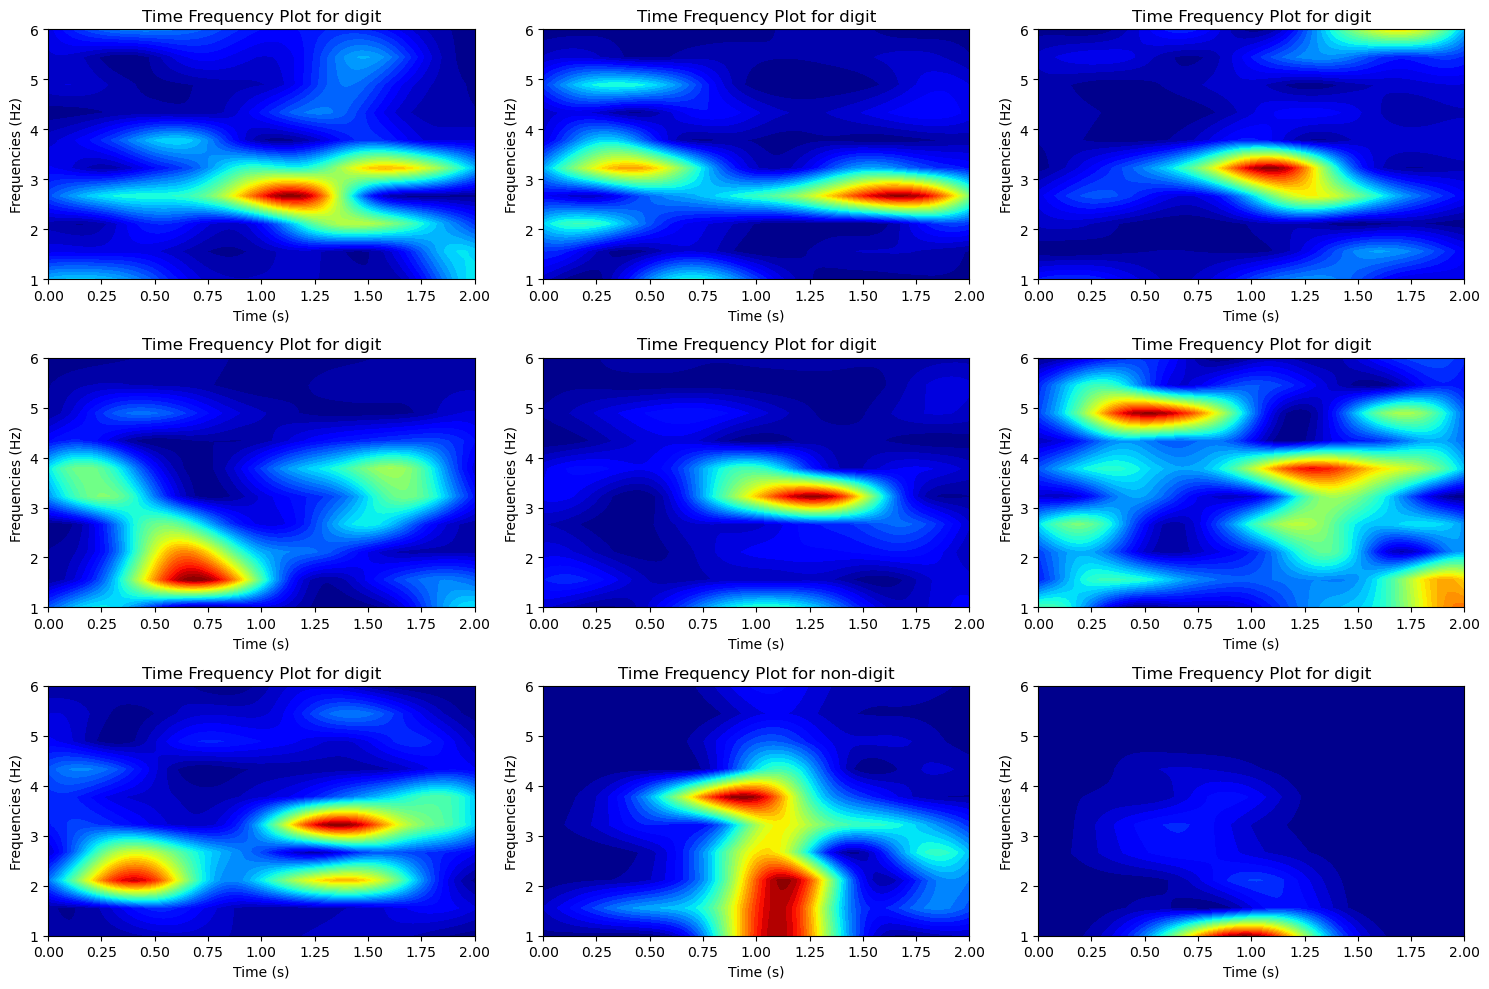

In [12]:
starting_freq = 1
end_freq = 6
num_frequencies = 10

#  Creates an array of time values starting from 0 to 2 seconds, with a total number of elements defined by median_length.
times = np.linspace(0, 2, median_length_mw)

nData = data_array_mw.shape[1]
cmwX, nKern, frex = get_cmwX(nData, freqrange=[starting_freq, end_freq], numfrex=num_frequencies)
tf = time_frequency(data_array_mw, cmwX, nKern)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i,ax in enumerate(axs.flat):
  x = random.randint(0, tf.shape[0])
  contour = ax.contourf(times, frex, tf[x,:,:], 40, cmap='jet')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequencies (Hz)')
  ax.set_title(f"Time Frequency Plot for {'non-digit' if codes_mw[x] == -1 else 'digit'}")

fig.tight_layout()